In [1]:
import cvxopt
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import cv2
import cvxpy as cvx
import dccp
from glob import *
import warnings
warnings. filterwarnings("ignore")
%matplotlib inline

In [2]:

def frames_to_video(input_path, output_path, fps, collision = True):
    '''
        Function to Concatenate given frames and fps into a video file.
        Input Arguments
        input_path  : Path to the input directory containing input frames
        output_path : Path to the output directory containing the video file
        fps         : Frames per Second of the output video
        Return
        Boolean     : True is Video written successfully, False if writing is not successful.
    '''
    image_files = glob(input_path)
    #print(image_files)    
    
    image_files = glob(input_path)
    final = len(image_files)
    
    if collision == False:
        location = './plots_temp' 
    else:
        location = './cc_plots_temp' 
        
        
    frames = [] 
    for f in range(0 + 1, 1 + final):
#         print(f)
        frame = cv2.imread(f"{location}/{f}.png")
#         print(f"{location}/{f}.png")
        height, width, channels = frame.shape
        size = (width, height)
        frames.append(frame)
        if f == final:
            for endingFrame in range(5):
                frames.append(frame)

    video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for frame in frames:
        video_writer.write(frame)

    video_writer.release()
    return True

## Obstacle avoidance

Robots in the real world, however, operate in much more exacting environments complete with static and dynamic actors. Obstacle avoidance is now a concern for the robot.

Below, we consider the static obstacle case, collisions are avoided by adding an obstacle avoidance constraint. The most popular method for the same is the Collision Cone constraint. 

While the collision cone constraint operates in an inertial frame of reference, depending on the application, this may not be a feasible formulation (take the example of a multi-agent dynamic system, it would be inefficient to compute and store collision cones for each pair of agents). The Velocity Obstacle is essentially the collision cone but in a non-inertial frame of reference. The ORCA constraint is useful when the task of collision avoidance is distributed amongst the agents (that is, every agent has to avoid colliding with every other obstacle as opposed to a single agent trying to avoid every obstacle). A dynamic scene with two actors can be converted into an inertial frame of reference and treated as a static obstacle avoidance problem.

In a scene with only dynamic actors, the concept of time scaling can be used in-hand with the Collision Cone / Velocity Obstacle / ORCA (Optimal Reciprocal Collision Avoidance) constraint. 

We use the collision cone formulation for static obstacles to add the collision avoidance constraint to our problem. It is given as: 

$$
(x_{robot} - x_{obstacle})^{2} + (y_{robot} - y_{obstacle})^{2} \geqslant R^{2}
$$

It is evident that the above constraint is non-convex (quadratic) - a circle, i.e. the LHS of the above equation, is a convex set. As we're searching for a point that lies outside of the convex set, our problem is no longer convex. We pass this constraint to our solver in order to obtain the navigation control inputs for the timestamp.

We optimize for safety by increasing the radius of the configuration space obstacle. We consider this the most important variable to optimize for as there will almost always be noise in the measurements that we take with sensors. As in the configuration space, the point robot is allowed to "just graze" the boundary of the obstacle, if the readings were even marginally erroneous then the robot may collide with the static obstacle. 

In [54]:
t_del = 1
v_init = np.array([10,10])

class ColCone_MPC_Agent:
    
    def __init__(self, start, goal, steps, vmax, obs, obs2):
        self.xpath = []
        self.ypath = []
        self.time = 0
        self.pos = start
        self.goal = goal
        self.v = np.array([0,0])
        self.steps = steps
        self.vmax = vmax
        self.obs = obs
        self.obs2 = obs2
        
    
    def traj_opti(self):
        
        self.xpath.append(self.pos[0])
        self.ypath.append(self.pos[1])
        if os.path.isdir("./cc_plots_temp"):
            shutil.rmtree("./cc_plots_temp")
        os.mkdir("./cc_plots_temp") 
        
        while(np.linalg.norm(self.pos - self.goal) > 0.5):
            
            v = cvx.Variable((2,1))
            obj = cvx.Minimize((cvx.norm(self.pos + v*t_del - self.goal))**2)
            constr = [ v[0]>=0, v[0]<= self.vmax, v[1]>=0, v[1]<=self.vmax]
#             print(f"The party's here to show {self.obs[self.time][0:2]}, {self.obs[self.time][2]}")
            constr += [ (cvx.norm(self.pos + v*t_del - self.obs[self.time][0:2].reshape(-1,1)))**2 >= (self.obs[self.time][2] + 0.5)**2]
            constr += [ (cvx.norm(self.pos + v*t_del - self.obs2[self.time][0:2].reshape(-1,1)))**2 >= (self.obs2[self.time][2] + 0.5)**2]
#             constr += [ (cvx.norm(self.pos + v*t_del - self.obs[min(self.steps, self.time + 1)][0:2].reshape(-1,1)))**2 >= (self.obs[min(self.steps, self.time + 1)][2] + 0.5)**2]
#             constr += [ (cvx.norm(self.pos + v*t_del - self.obs2[min(self.steps, self.time + 1)][0:2].reshape(-1,1)))**2 >= (self.obs2[min(self.steps, self.time + 1)][2] + 0.5)**2]
#             constr += [ (cvx.norm(self.pos + v*t_del - self.obs[self.time + 1][0:2].reshape(-1,1)))**2 >= (self.obs[self.time + 1][2] + 0.5)**2]
#             constr += [ (cvx.norm(self.pos + v*t_del - self.obs2[self.time + 1][0:2].reshape(-1,1)))**2 >= (self.obs2[self.time + 1][2] + 0.5)**2]
            prob = cvx.Problem(obj, constr)
            print(dccp.is_dccp(prob))
            result = prob.solve(method = 'dccp')
#             print('v = ', v.value)

            self.pos[0] = self.pos[0] + v[0].value * t_del
            self.pos[1] = self.pos[1] + v[1].value * t_del
            self.xpath.append(self.pos[0])
            self.ypath.append(self.pos[1])
            self.time += 1
#             print(self.time, self.pos)
 
            self.visualize_traj()
    
        frames_to_video("./cc_plots_temp/*.png", "./Quadratic-programming-velocity-obstacle2-4n.mp4", 5, collision = True)
   

    def visualize_traj(self):

        fig, ax = plt.subplots(figsize = (15, 15), dpi = 80)
        ax.set_xlim([0, 35])
        ax.set_ylim([0, 35])  
        ax.plot(self.pos[0], self.pos[1], 'o', color = 'orangered', markersize = 5)
        ax.plot(self.goal[0], self.goal[1], '^', color = 'lawngreen', markersize = 20)
        a_circle = plt.Circle(xy = (self.obs[self.time][0], self.obs[self.time][1]), radius = self.obs[self.time][2], alpha = 0.7, color = 'aqua', edgecolor = 'pink' )
        ax.set_aspect(1)
        ax.add_patch(a_circle)
        a_circle2 = plt.Circle(xy = (self.obs2[self.time][0], self.obs2[self.time][1]), radius = self.obs2[self.time][2], alpha = 0.7, color = 'aqua', edgecolor = 'pink' )
        ax.set_aspect(1)
        ax.add_patch(a_circle2)
        
        fig.suptitle("Timestamp " + str(self.time), fontsize = 20, color = 'green')
        x_path = np.array(self.xpath)
        y_path = np.array(self.ypath)
        ax.plot(x_path, y_path, color = 'gold')

        ax.set_yticklabels([])
        ax.set_xticklabels([])
        fig.savefig("./cc_plots_temp/" + str(self.time) + ".png")

        fig.show()
 

In [55]:
timestamps = 40
obst = np.array([np.hstack((np.linspace(6.0, 9.0, timestamps).reshape(-1,1), np.hstack((np.linspace(8.0, 11.0, timestamps).reshape(-1,1), 2 * np.ones(timestamps).reshape(-1,1)))))])

obst2 = np.array([np.hstack((np.linspace(22.0, 13.0, timestamps).reshape(-1,1), np.hstack((np.linspace(19.0, 13.0, timestamps).reshape(-1,1), 2 * np.ones(timestamps).reshape(-1,1)))))])

obst = np.squeeze(obst)
obst2 = np.squeeze(obst2)

print(obst.shape)
print(obst2.shape)


(40, 3)
(40, 3)


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


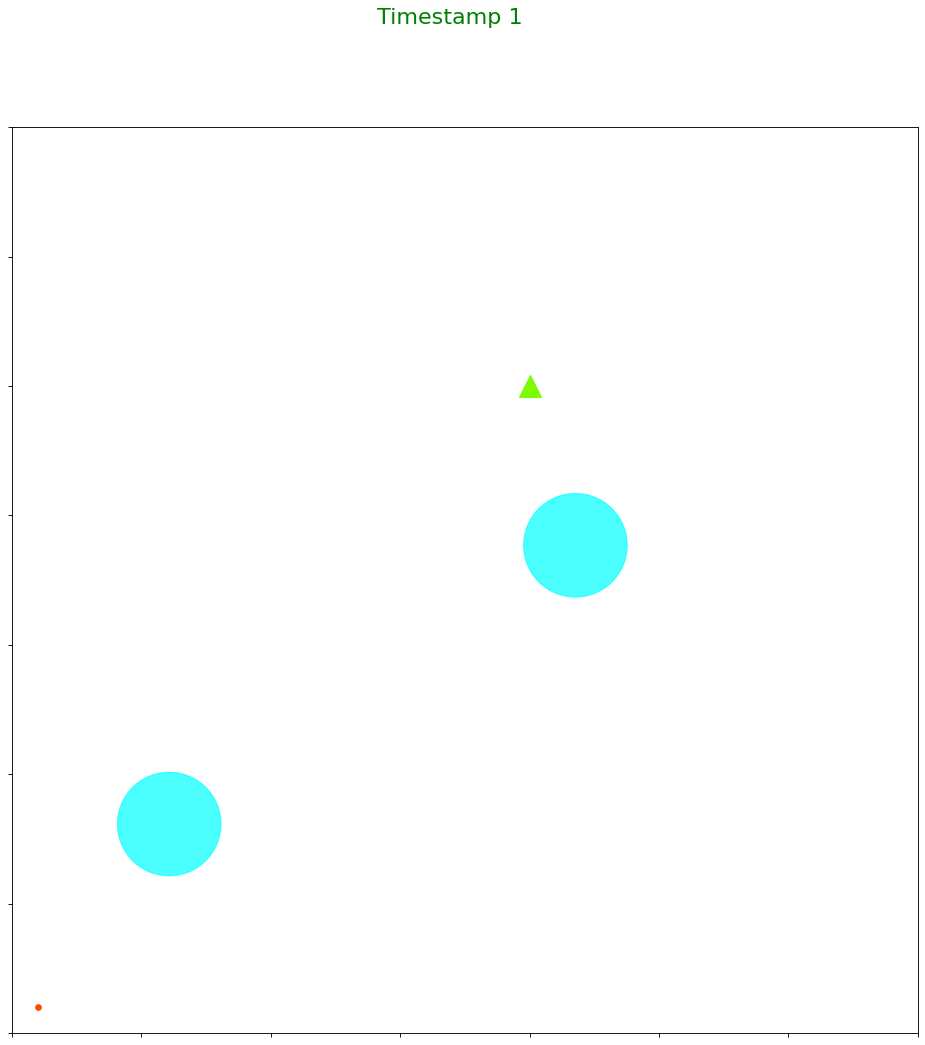

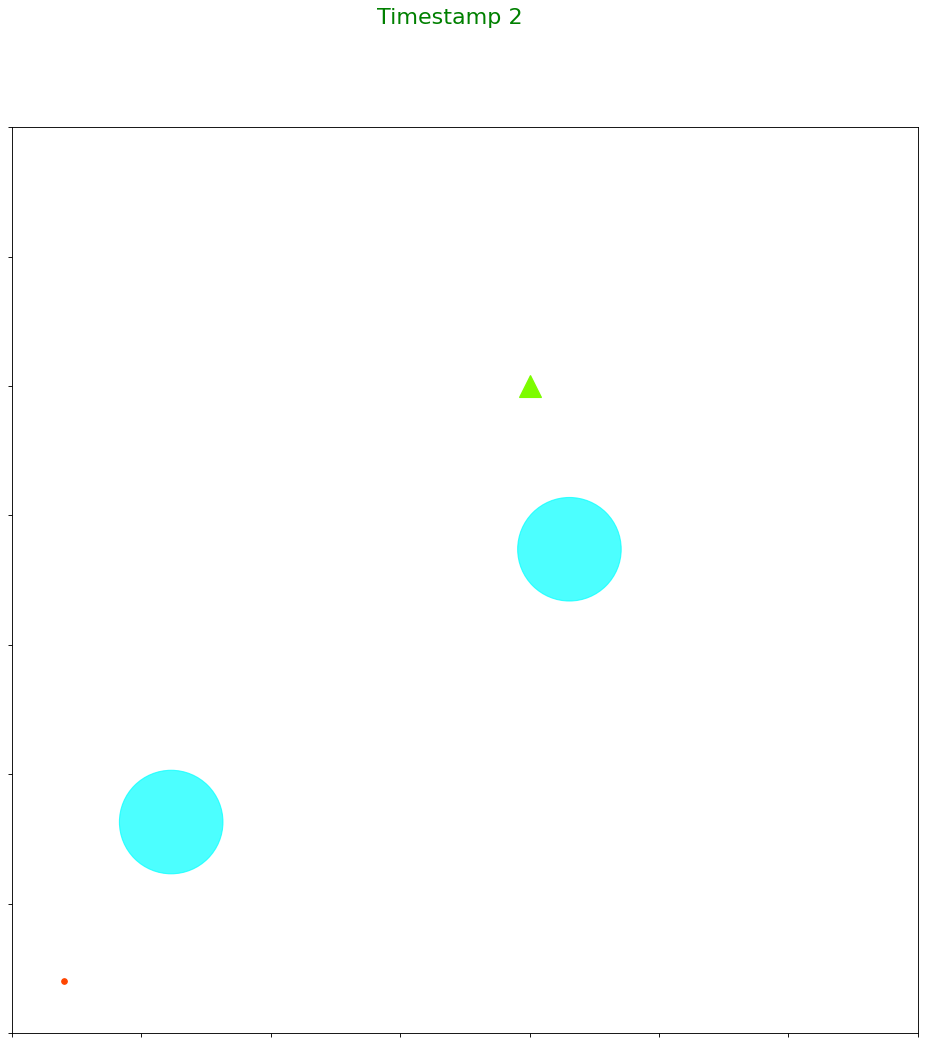

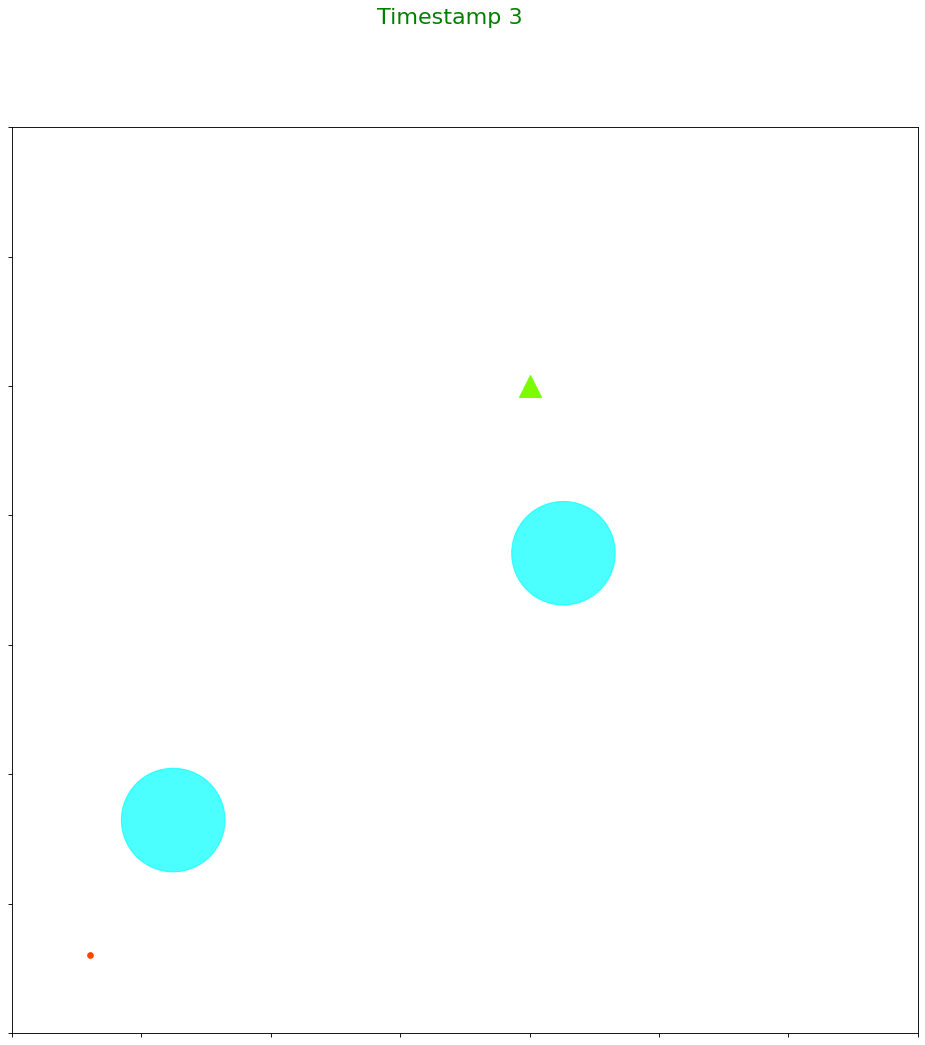

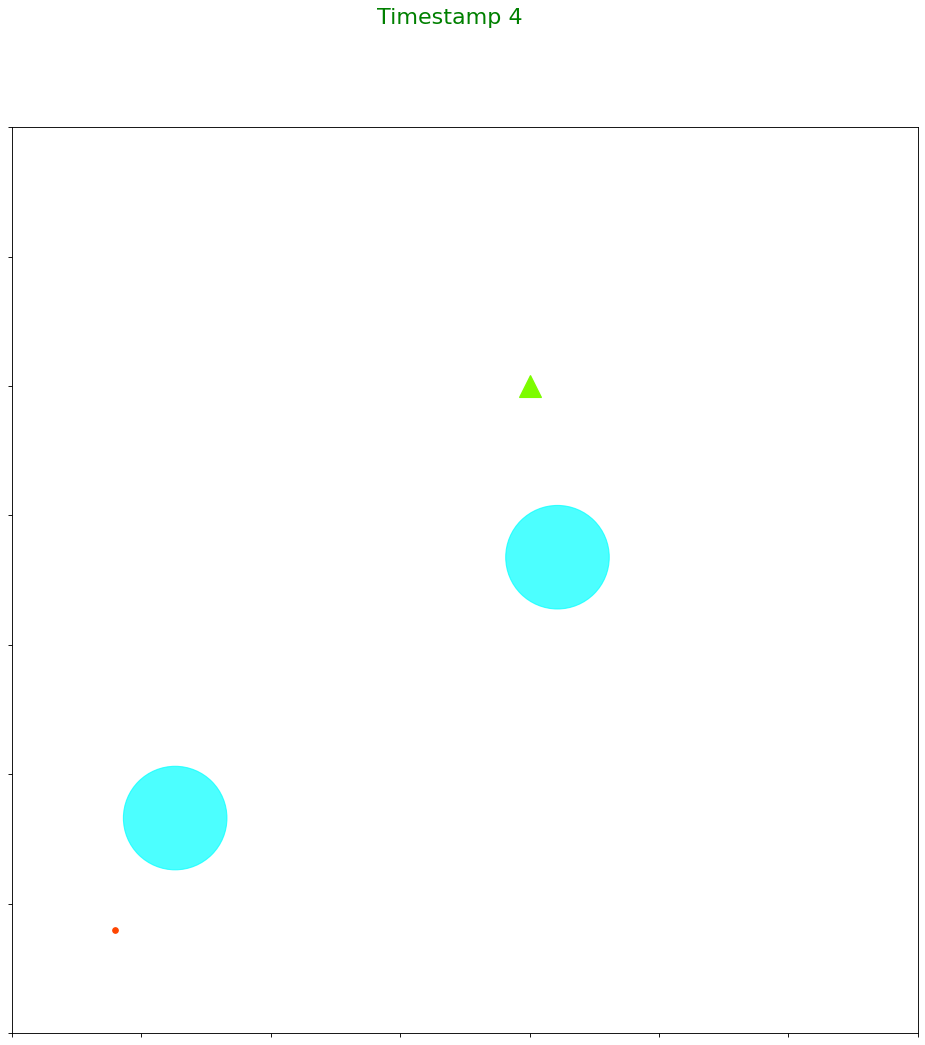

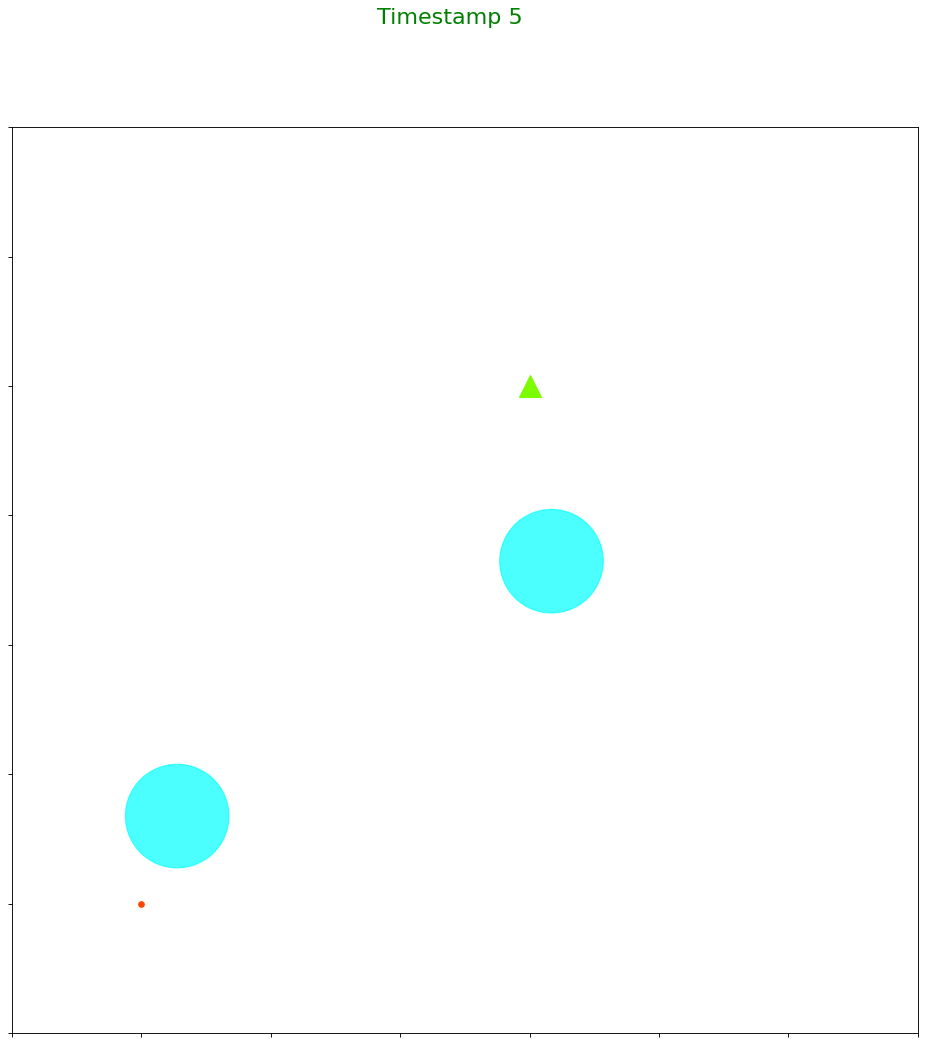

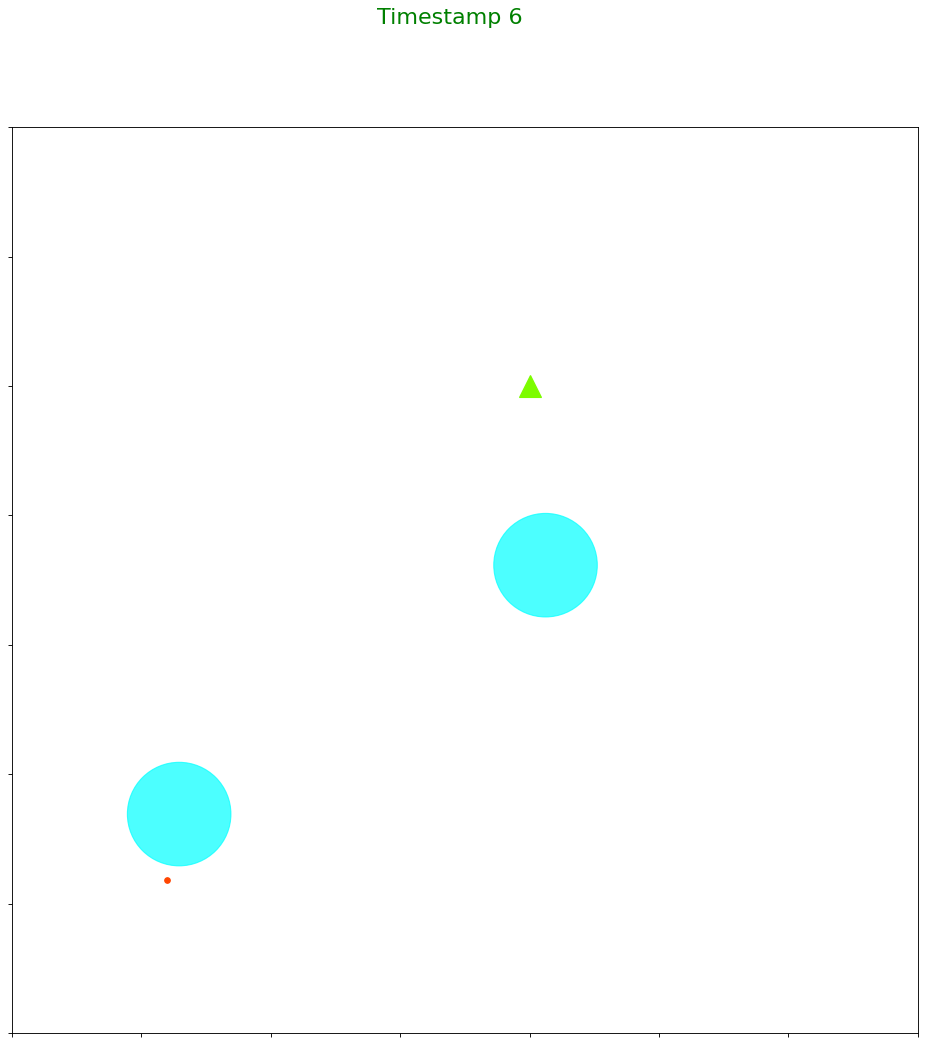

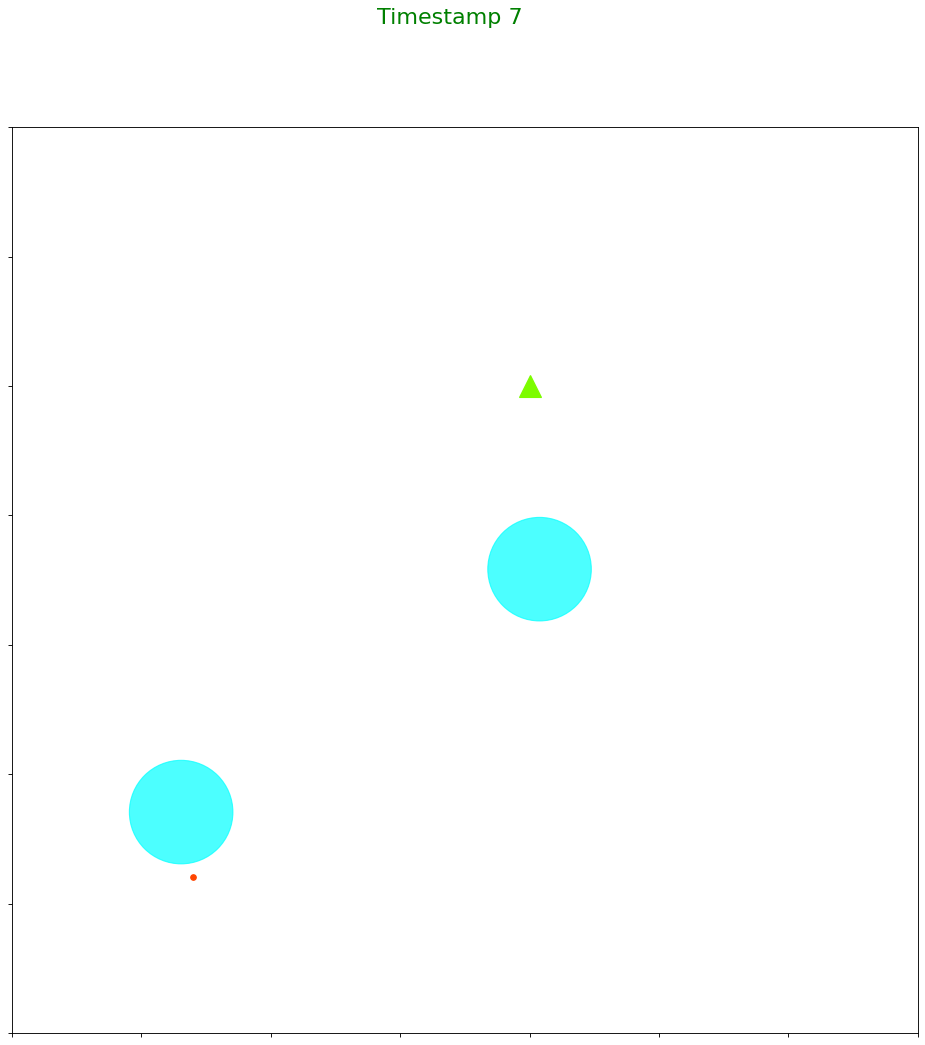

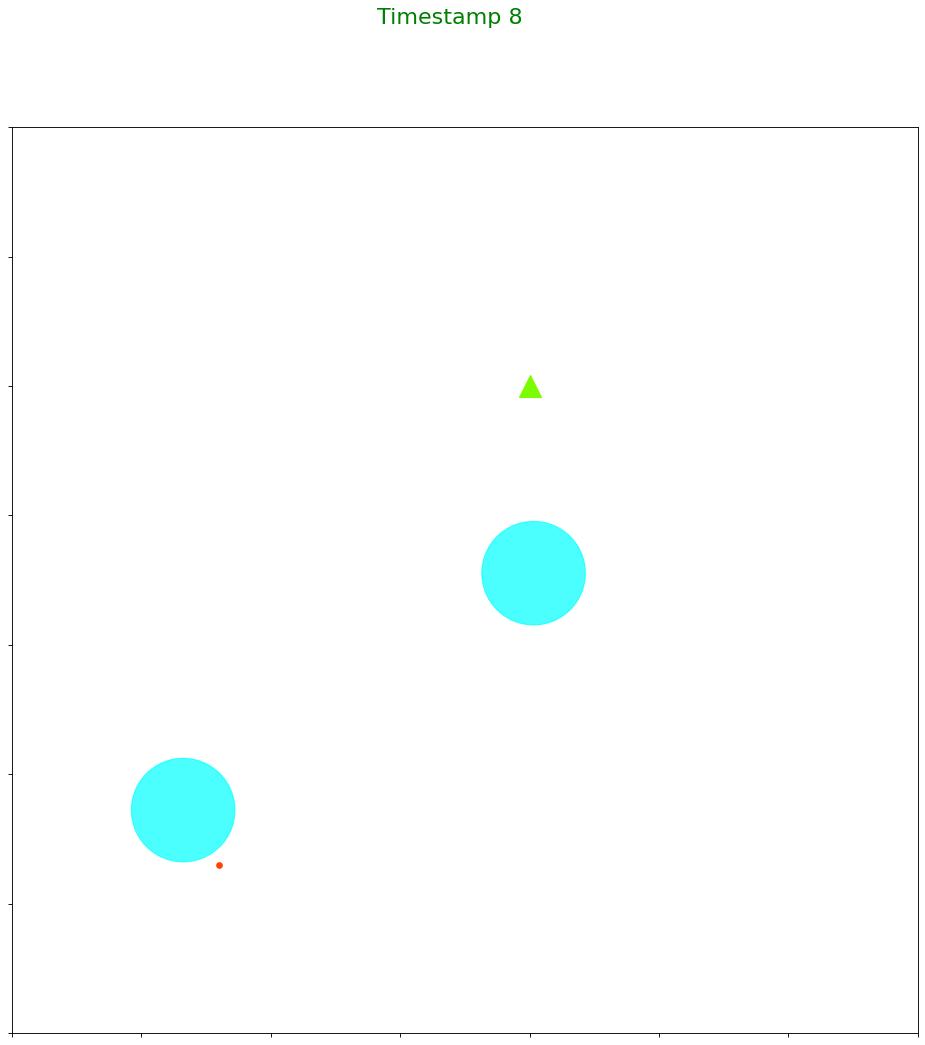

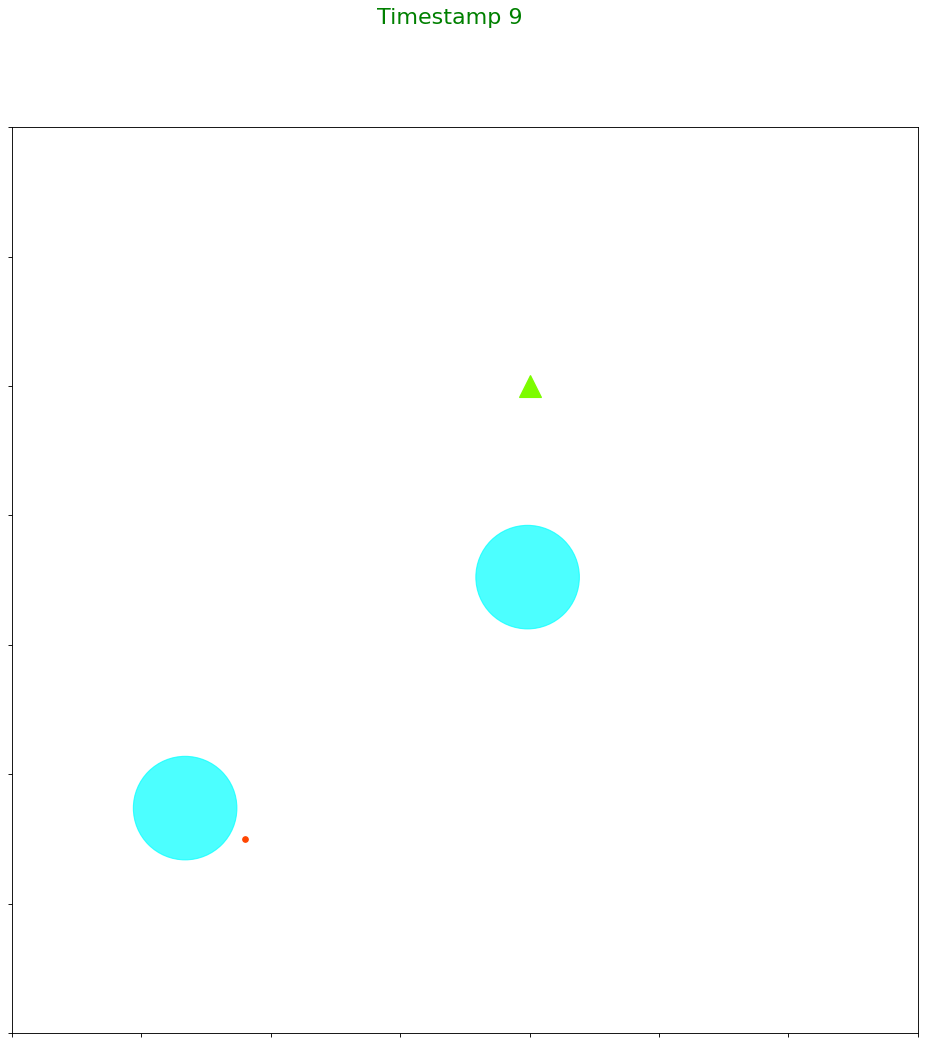

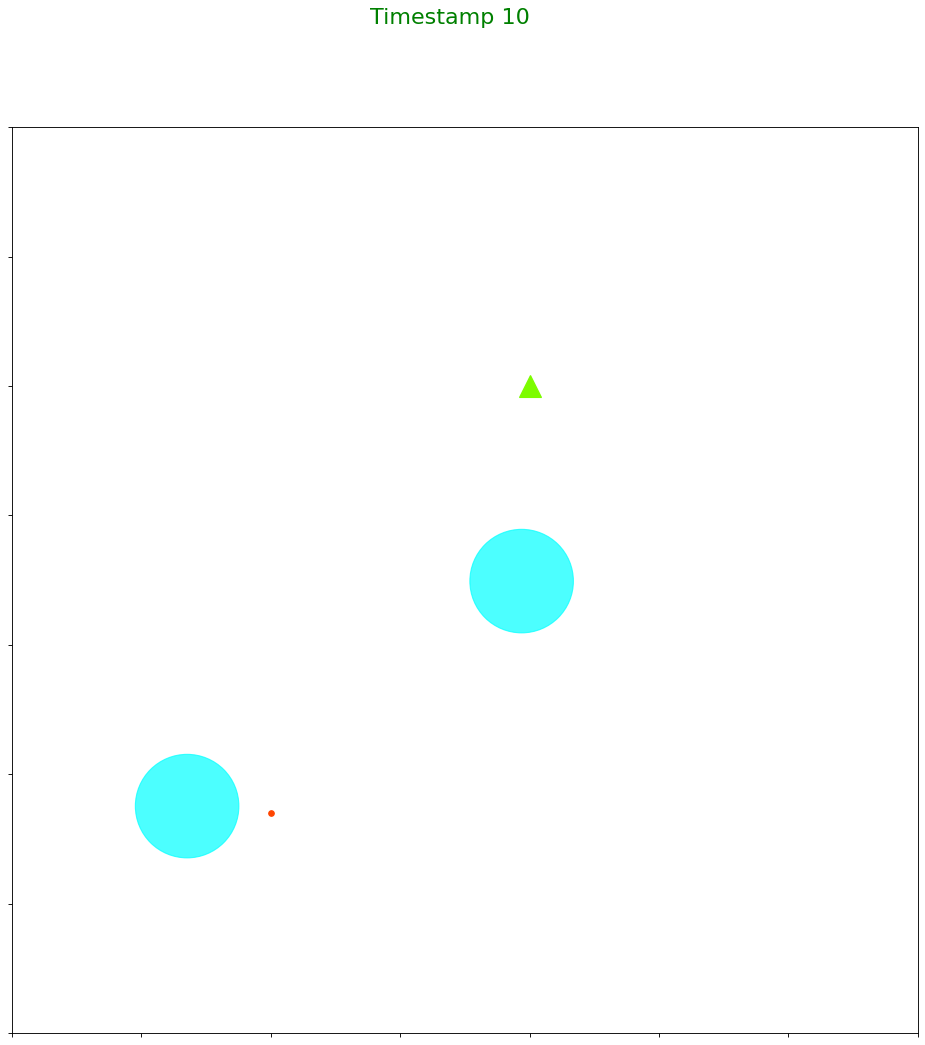

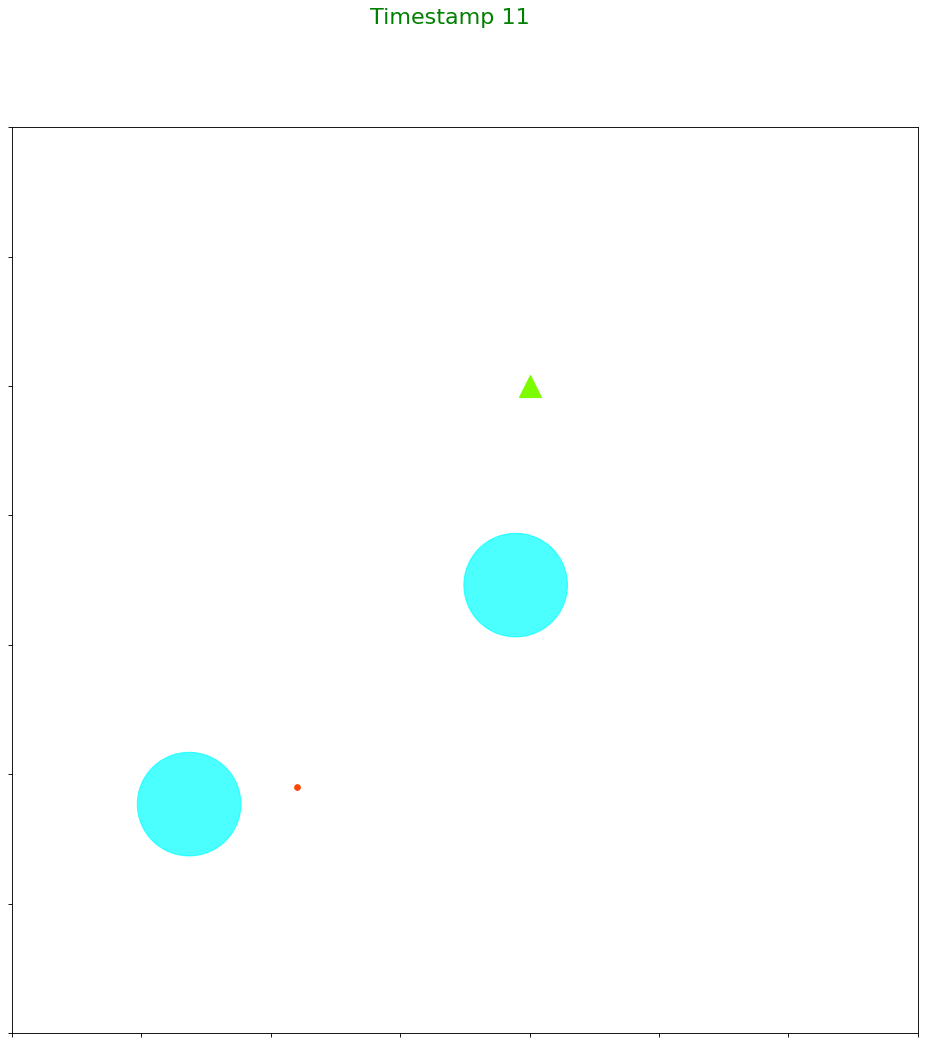

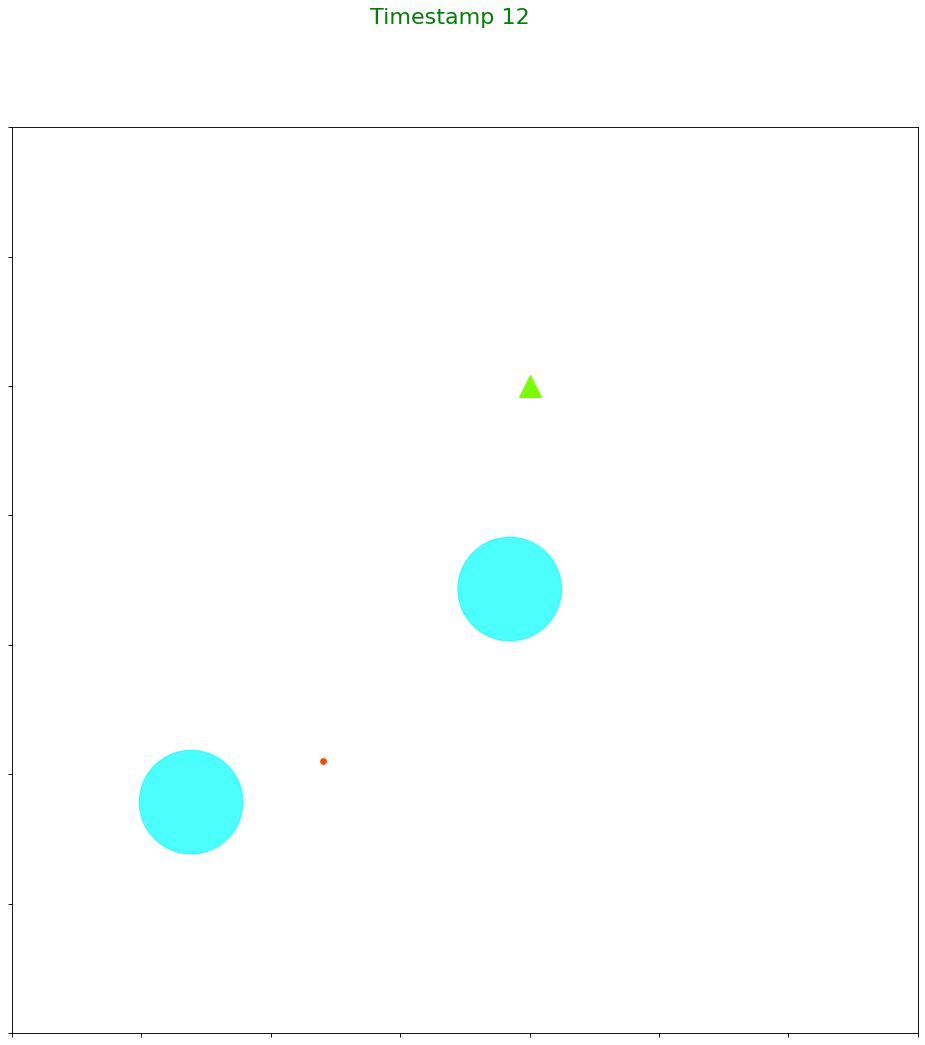

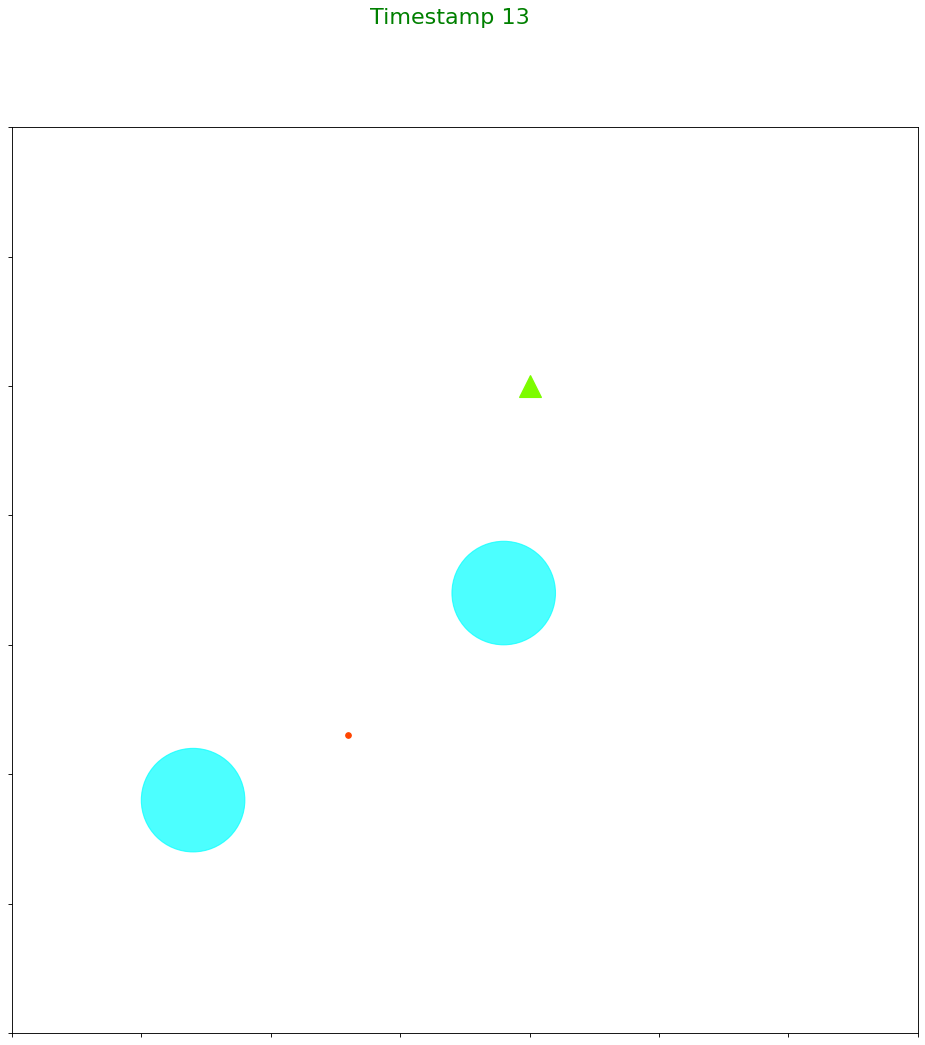

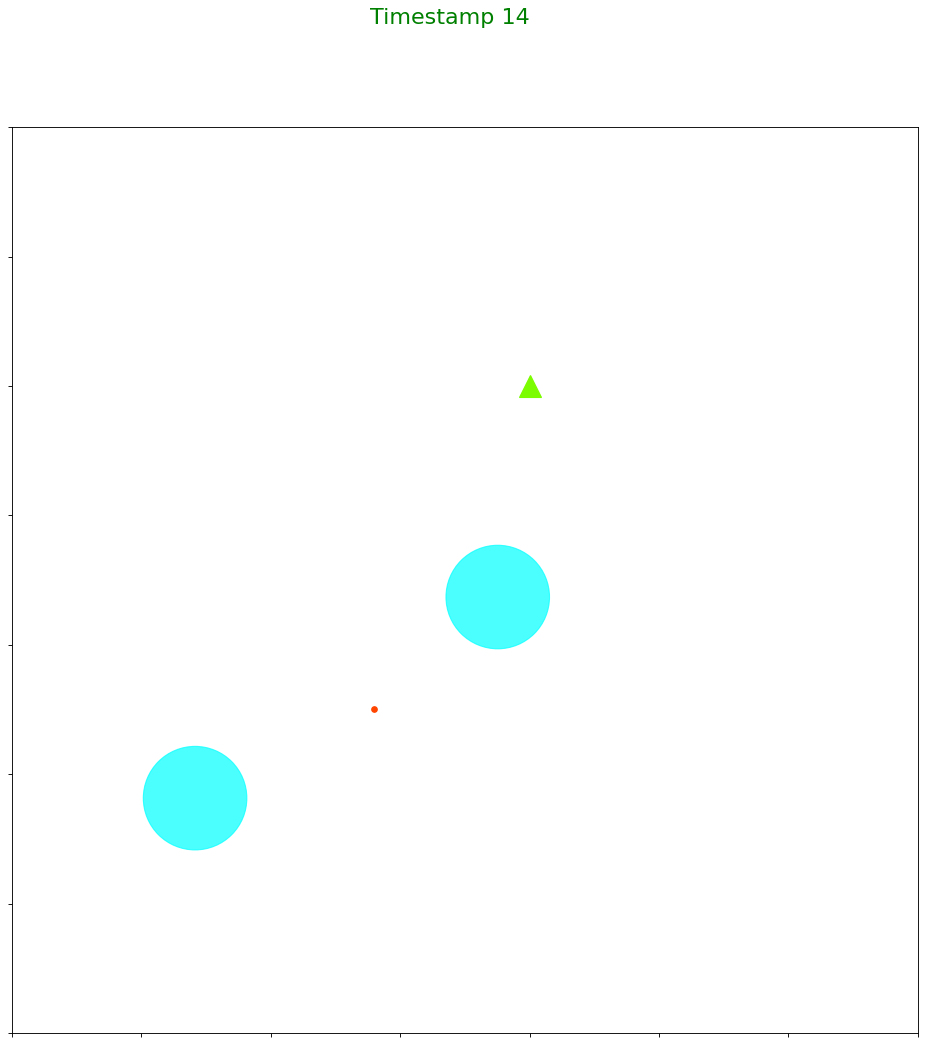

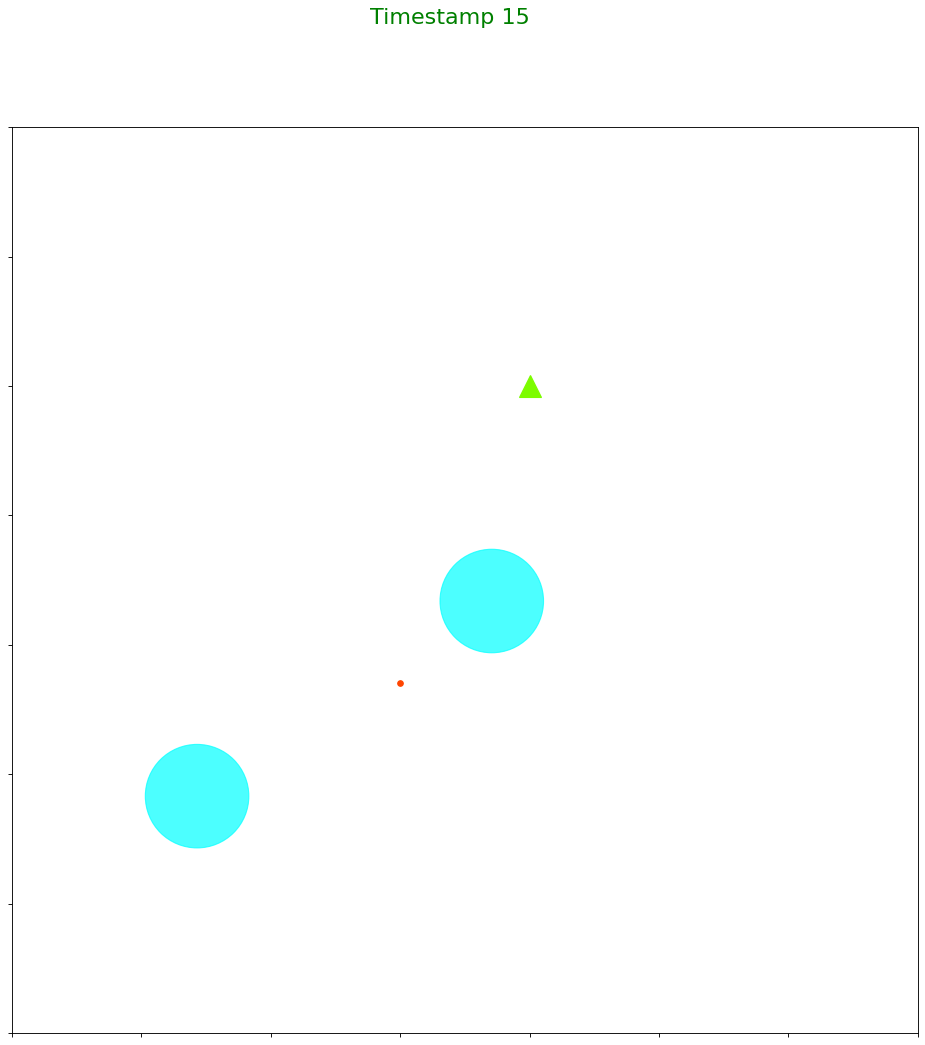

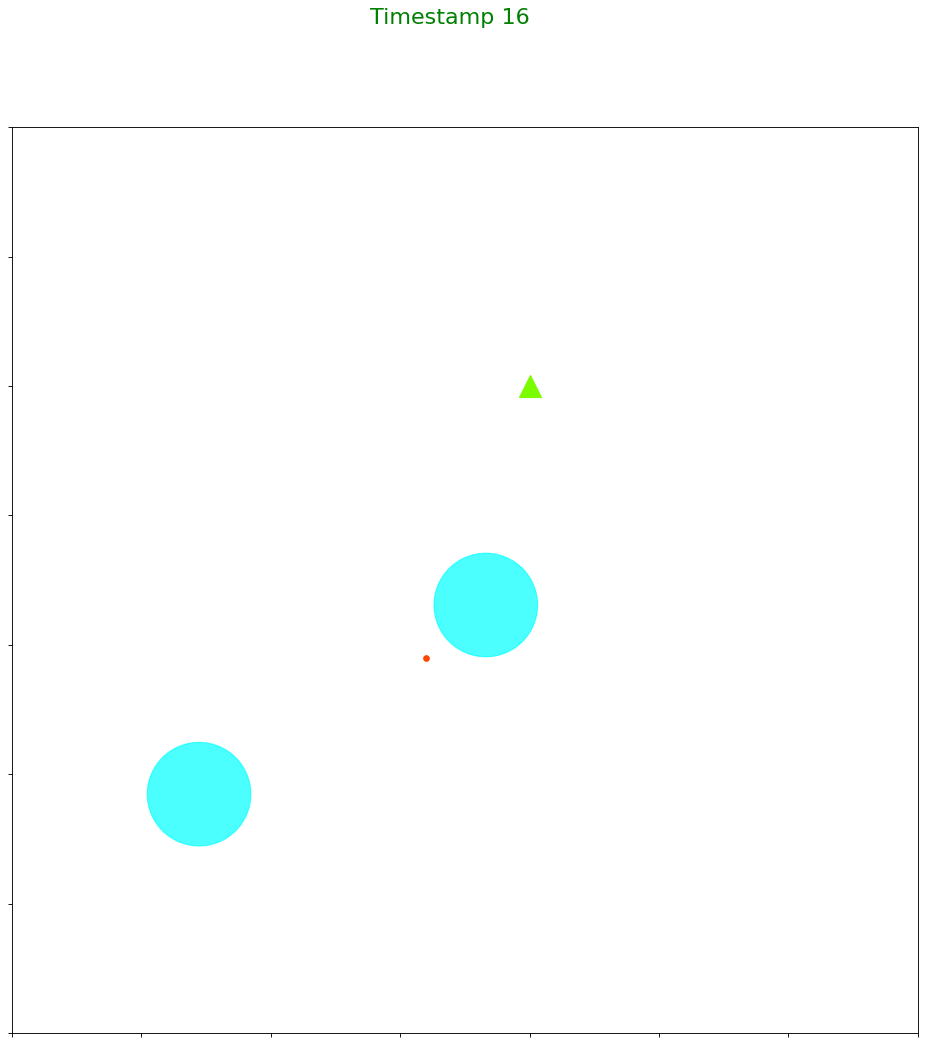

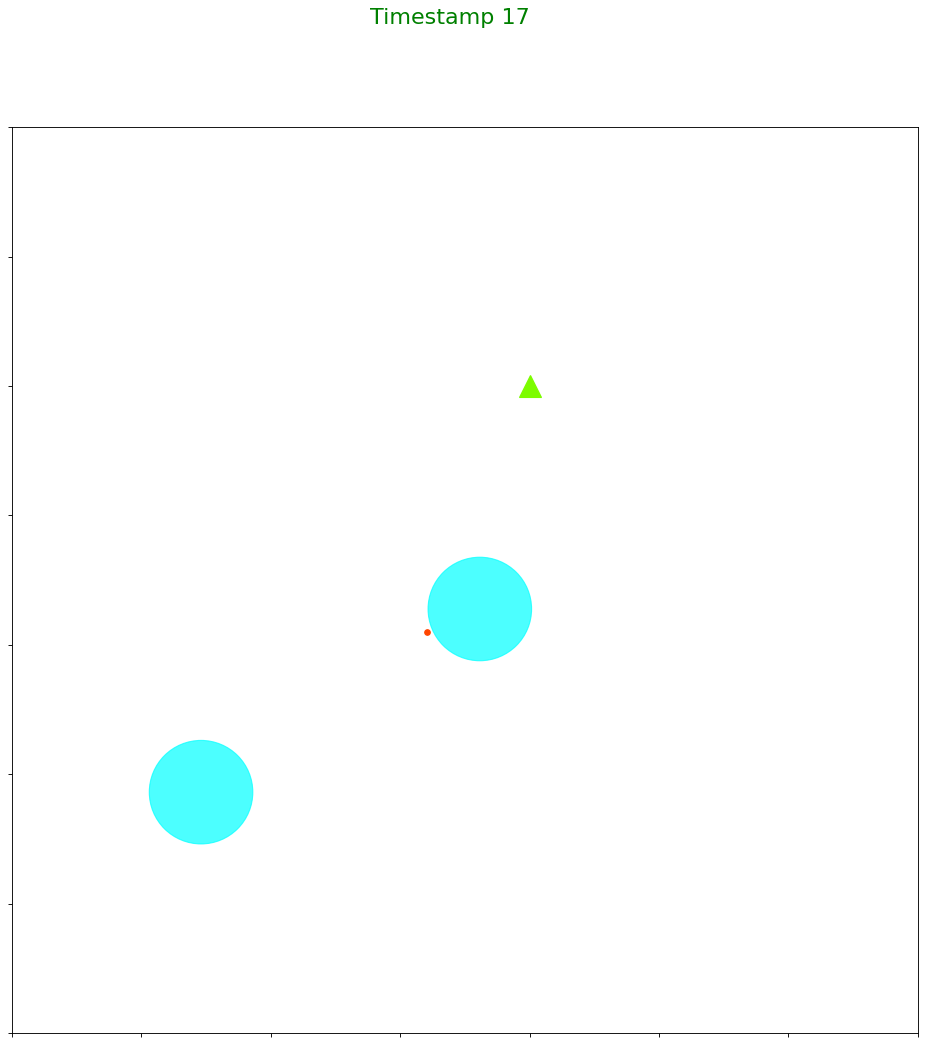

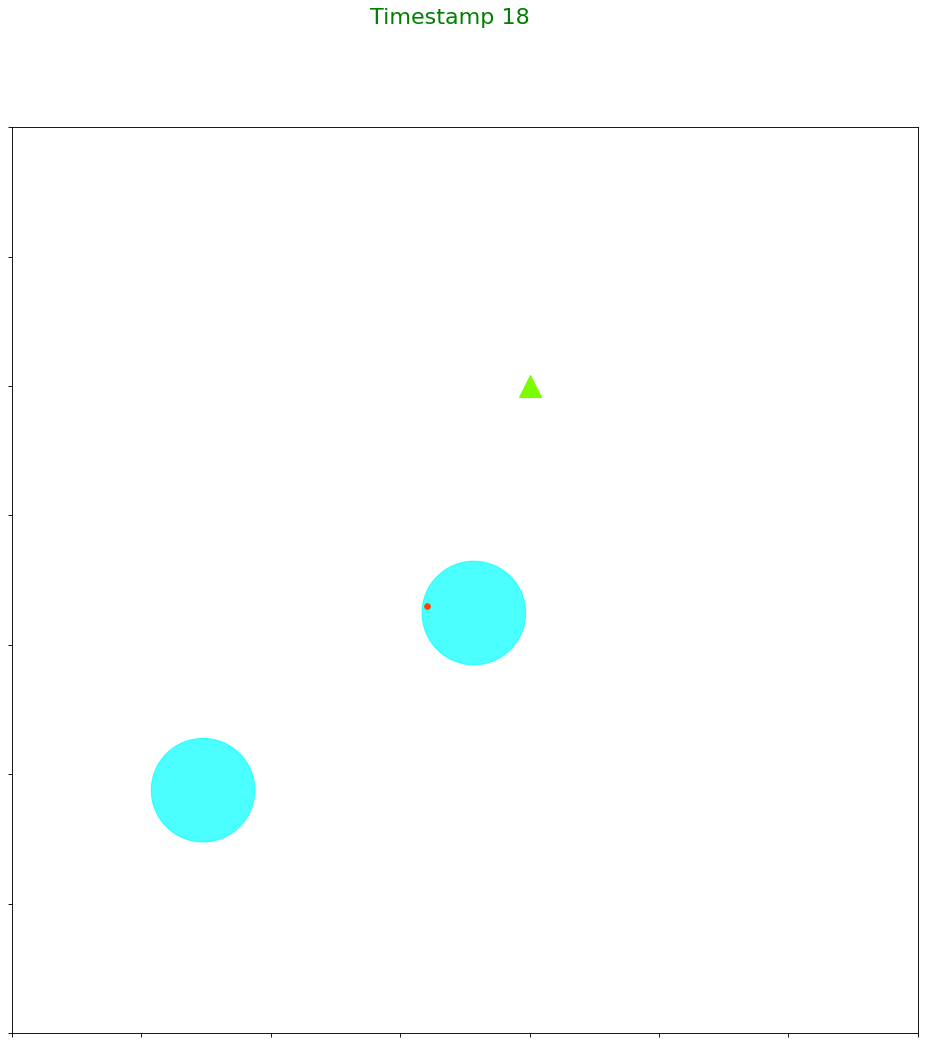

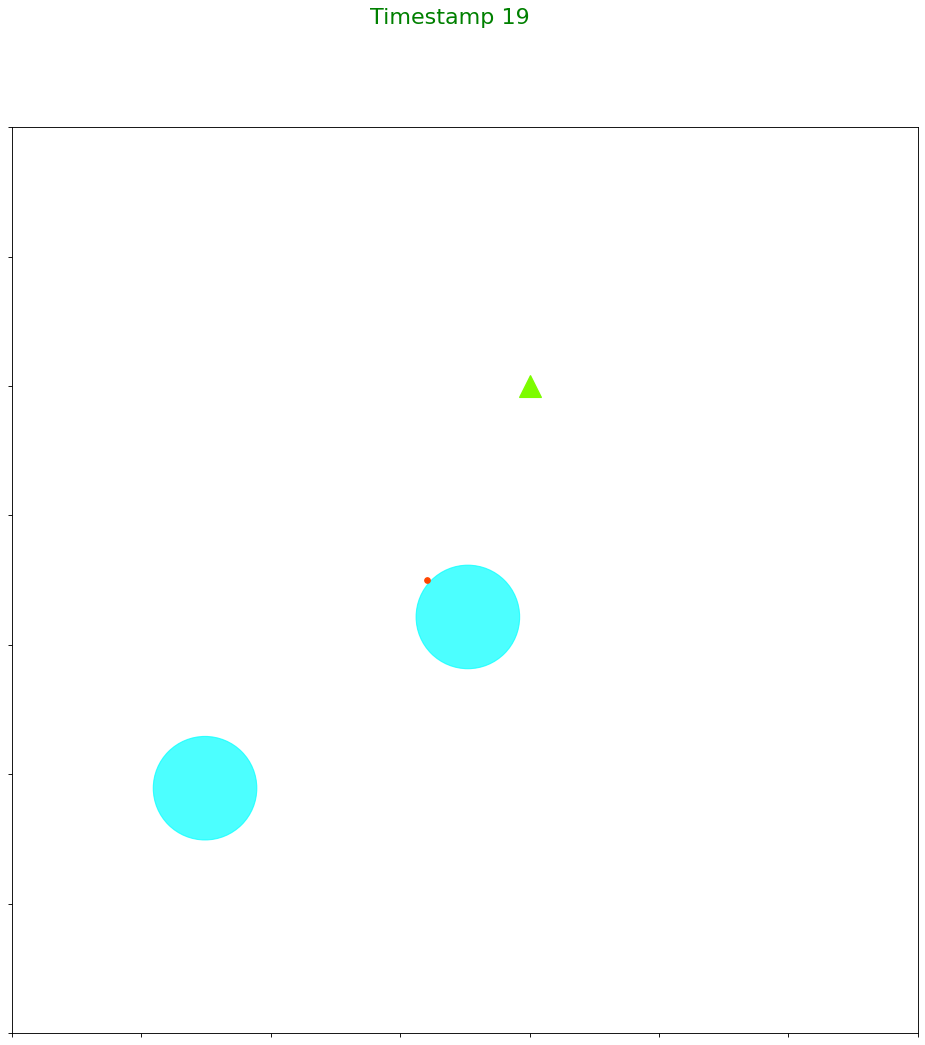

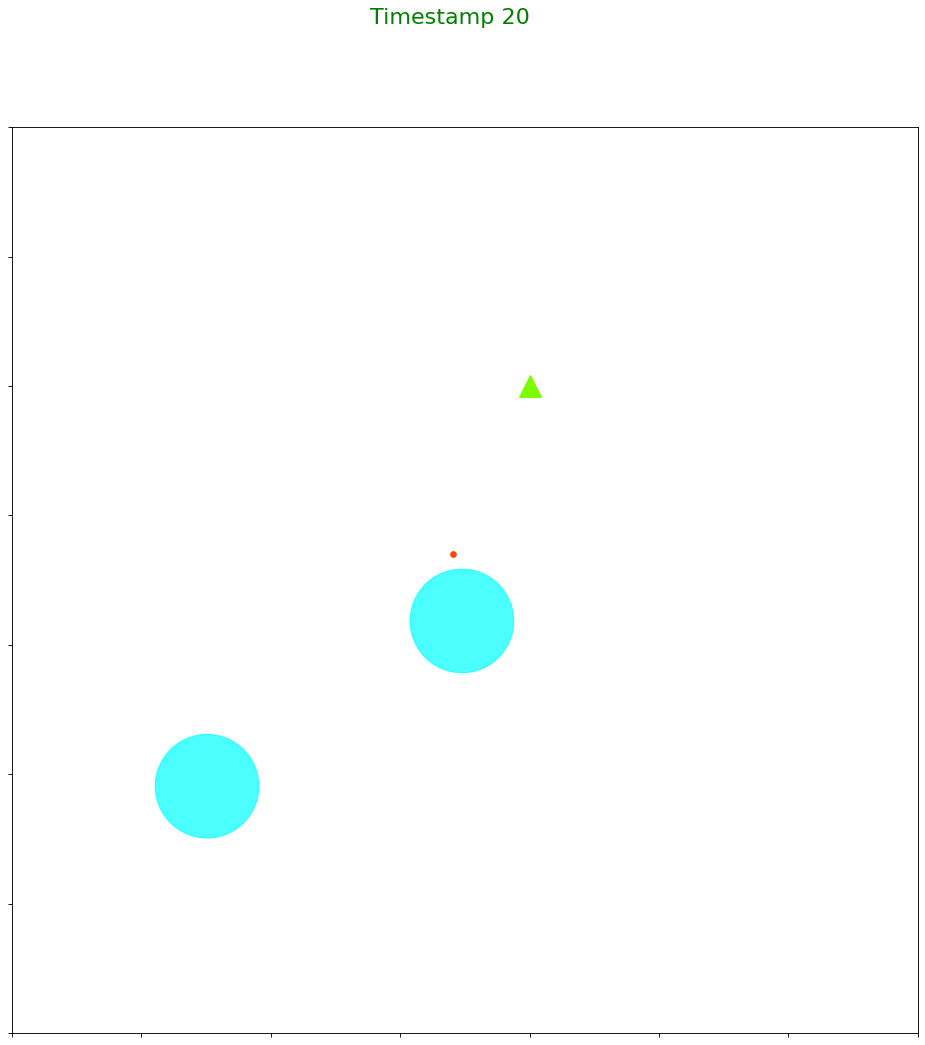

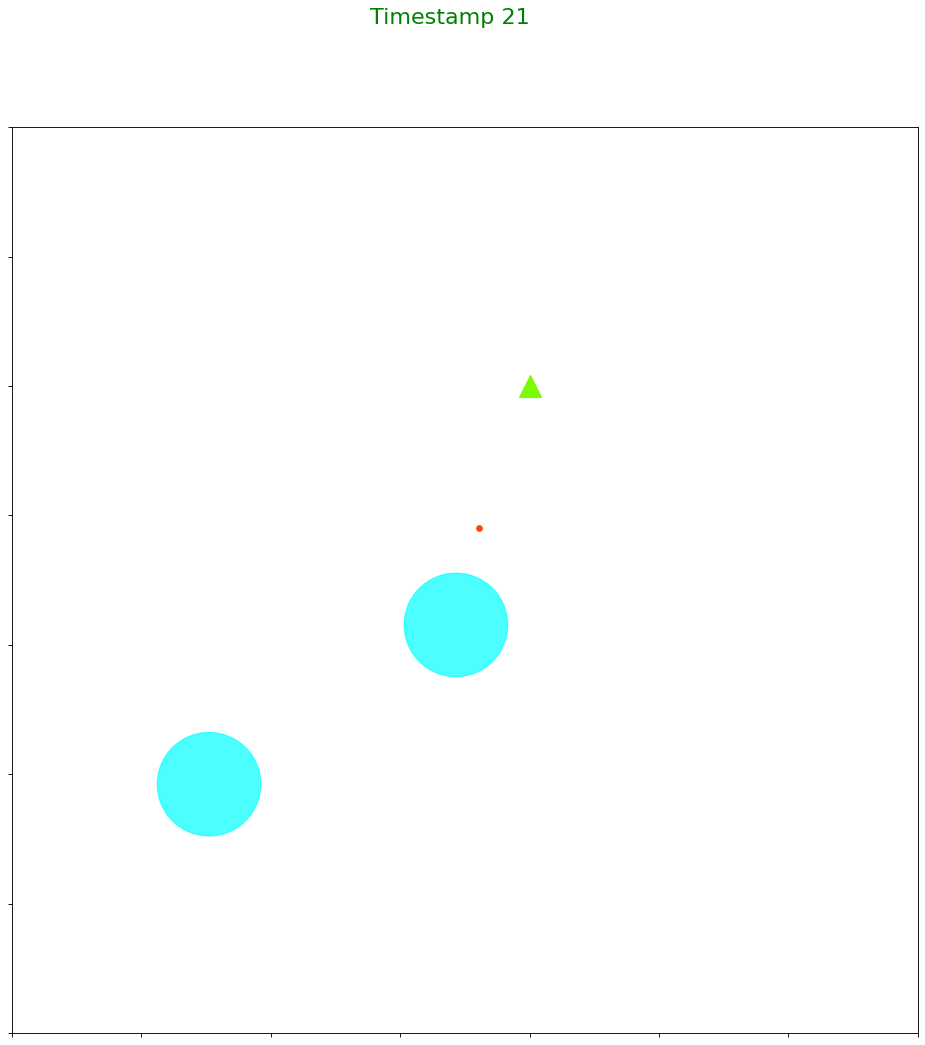

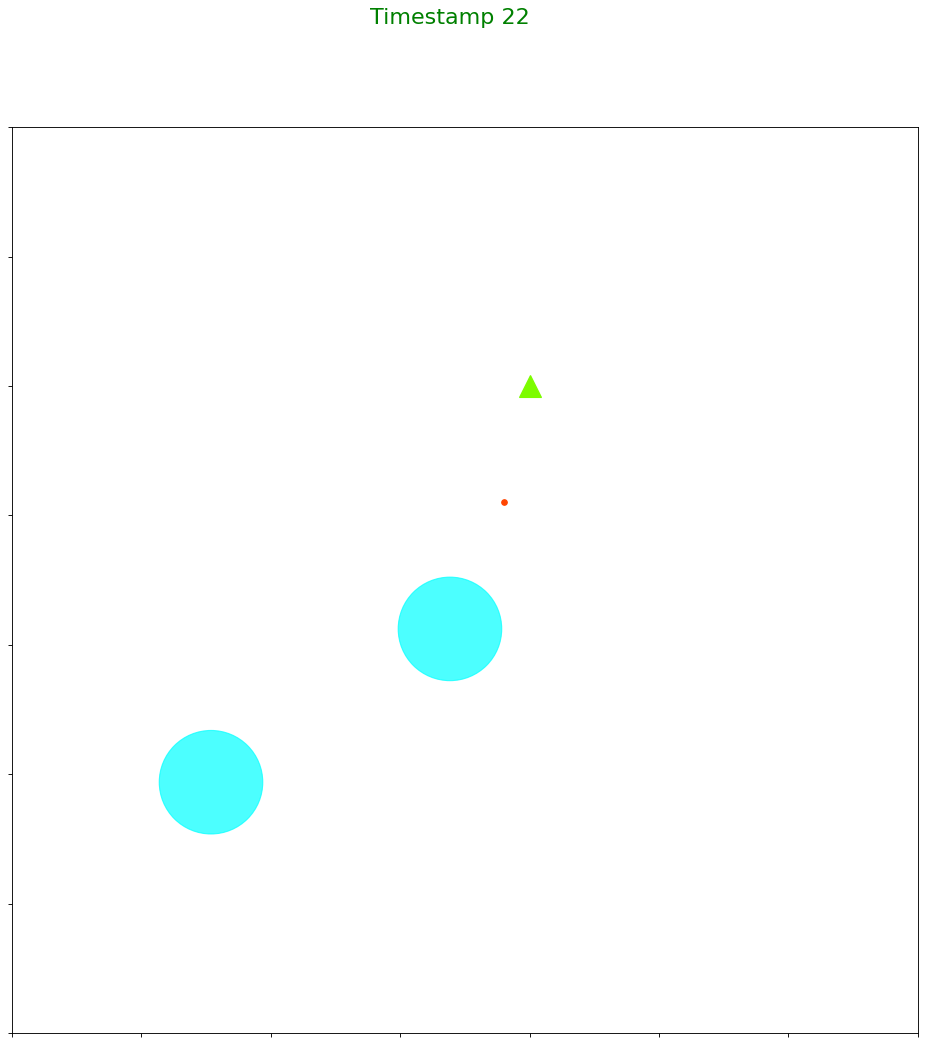

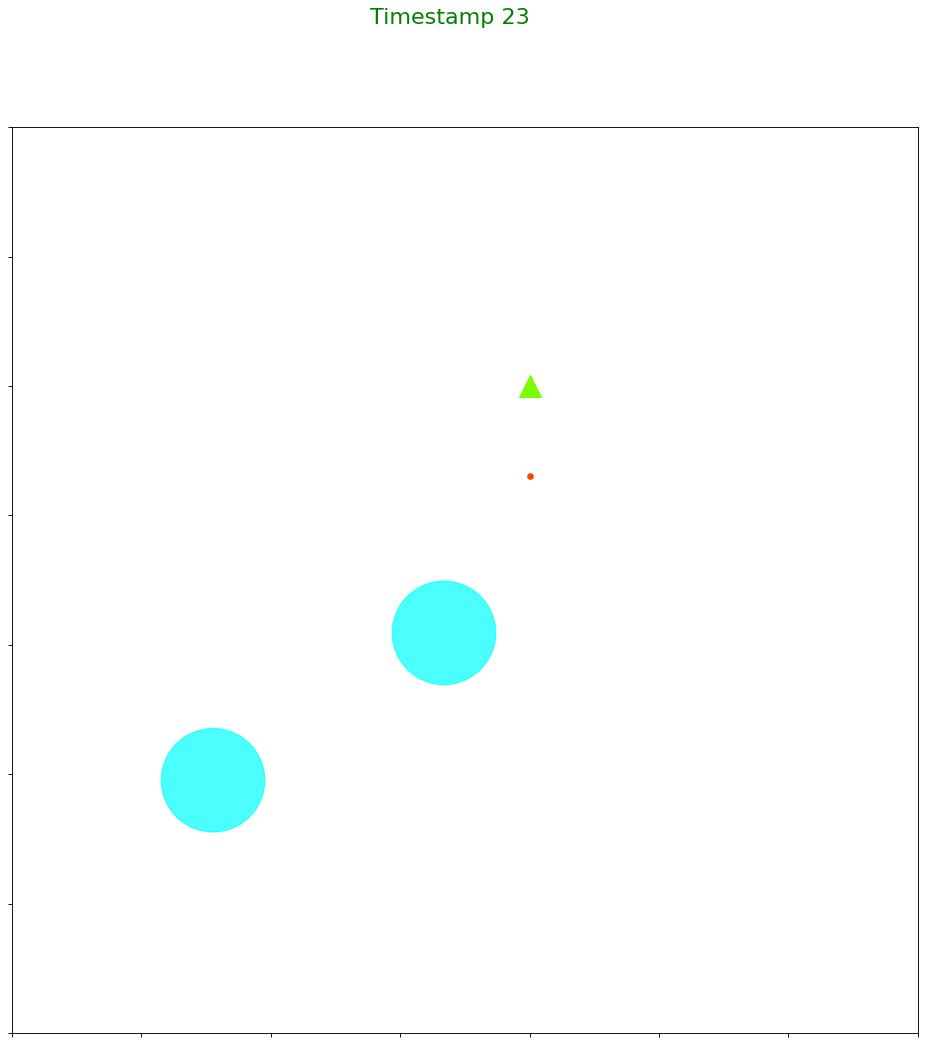

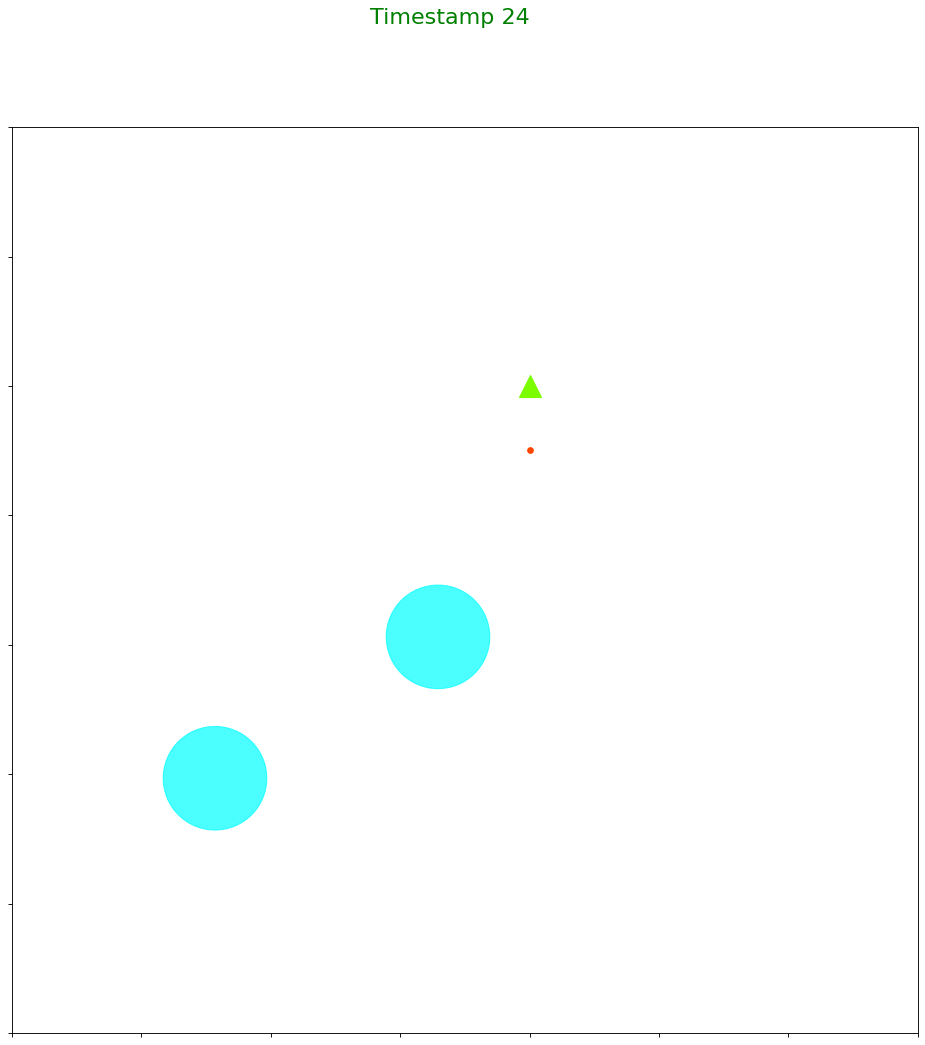

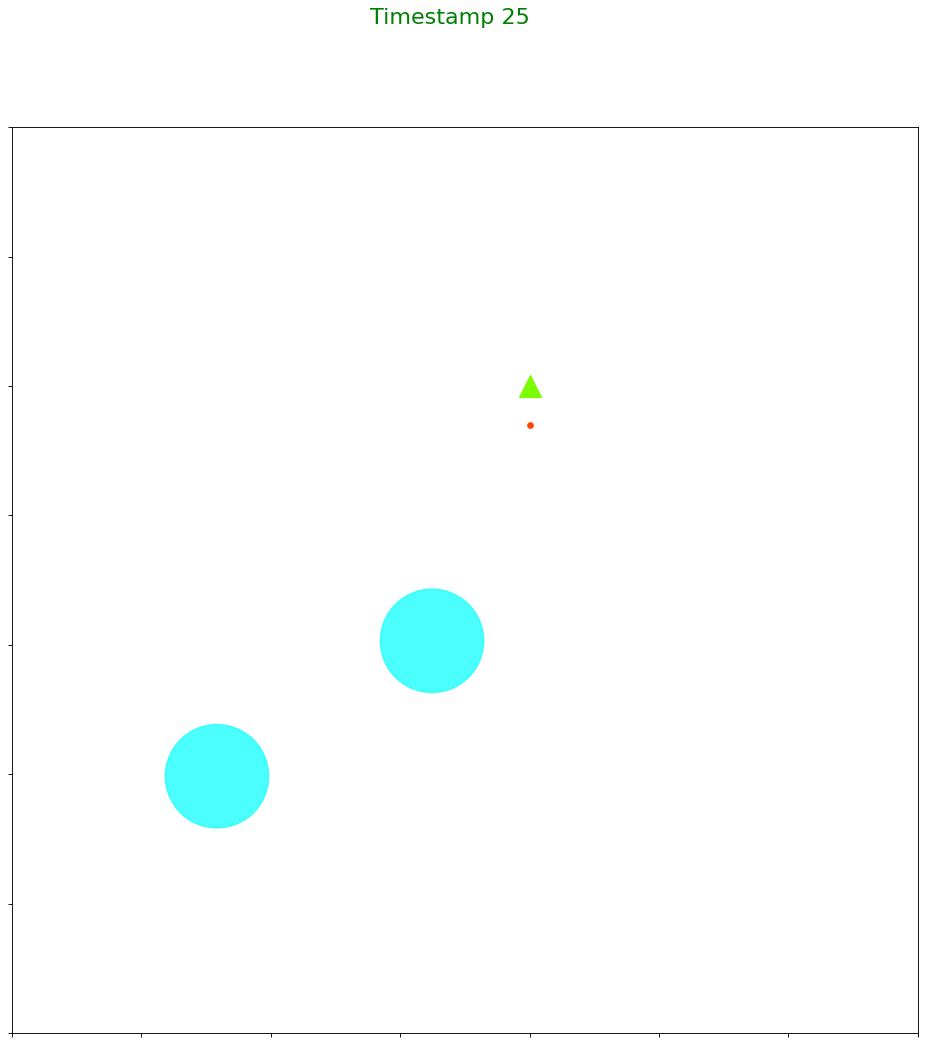

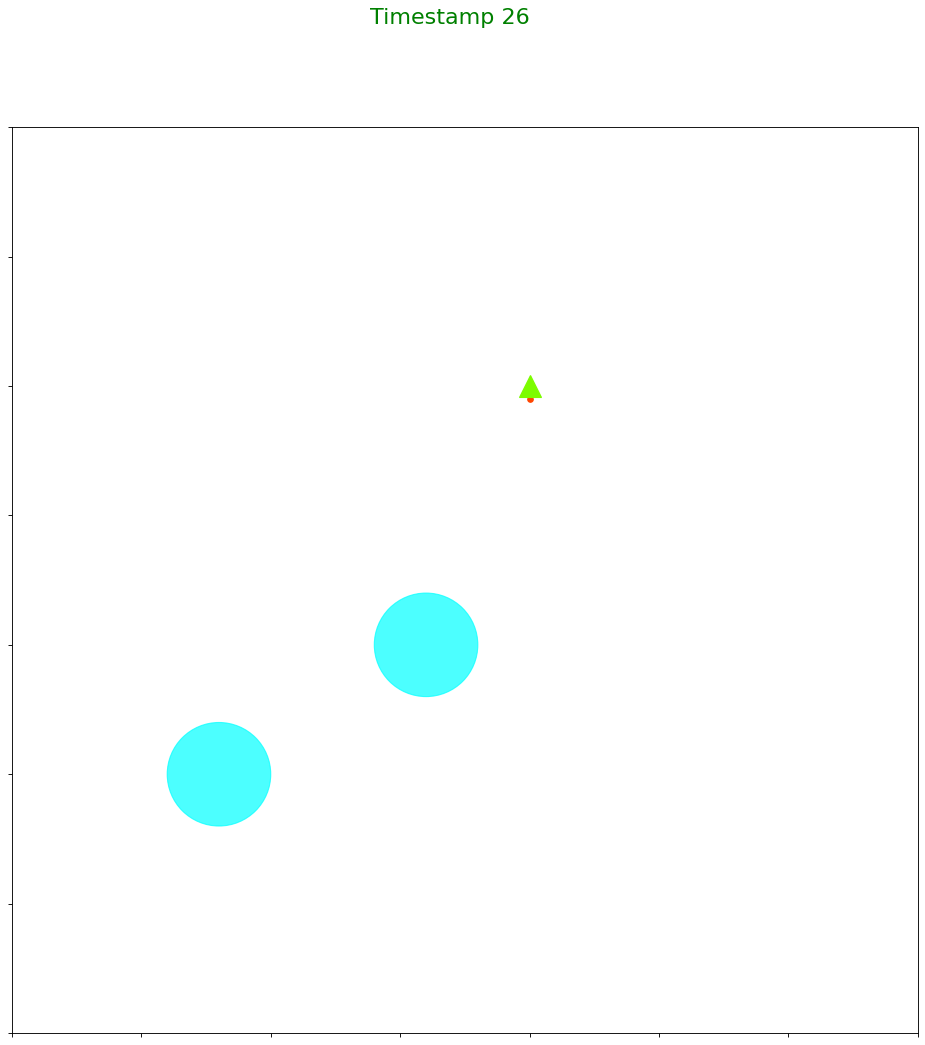

In [56]:
bot = ColCone_MPC_Agent(np.array([0.0,0.0]).reshape((2,1)),np.array([20.0,25.0]).reshape((2,1)),timestamps, 1, obst, obst2)
bot.traj_opti()